In [1]:
import matplotlib
import numpy as np
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import galsim
from copy import deepcopy
import random
import json
from lenstronomy.Util import correlation

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

import mejiro
from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs
from mejiro.lenses import lens_util
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.synthetic_image import SyntheticImage
from mejiro.exposure import Exposure
from mejiro.plots import plot_util
from mejiro.engines import webbpsf_engine
from mejiro.instruments.roman import Roman

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-068
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


In [2]:
pipeline_params = util.hydra_to_dict(config.pipeline)
debugging = pipeline_params['debugging']
# debugging = True  # TODO TEMP

if debugging:
    pipeline_dir = f'{config.machine.pipeline_dir}_dev'
else:
    pipeline_dir = config.machine.pipeline_dir

detectable_lenses = lens_util.get_detectable_lenses(pipeline_dir, with_subhalos=False, verbose=True)

100%|██████████| 18/18 [00:12<00:00,  1.44it/s]


In [117]:
band = 'F129'
snr_cut = 200
logm_cut = 13
zp = 26.3194  # zeropoint for F129 SCA01
sca = 1
sca_position = (2048, 2048)
instrument_params = {
    'detector': sca,
    'detector_position': sca_position
}
roman = Roman()
rng = galsim.UniformDeviate(42)

num_pix = 51  # pipeline_params['num_pix']
side = 5.61  # pipeline_params['side']
grid_oversample = pipeline_params['grid_oversample']
final_pixel_side = 45  # pipeline_params['final_pixel_side']
exposure_time = 584  # pipeline_params['exposure_time']
supersampling_factor = pipeline_params['supersampling_factor']
supersampling_compute_mode = pipeline_params['supersampling_compute_mode']

# get PSF
psf_cache_dir = os.path.join(config.machine.data_dir, 'cached_psfs')
psf_id = webbpsf_engine.get_psf_id(band, sca, sca_position, grid_oversample, 101)
psf = webbpsf_engine.get_cached_psf(psf_id, psf_cache_dir, verbose=False)

module_path = os.path.dirname(mejiro.__file__)
zp_dict = json.load(open(os.path.join(module_path, 'data', 'roman_zeropoint_magnitudes.json')))

In [118]:
# get lenses
lenses = [l for l in detectable_lenses if l.snr > snr_cut and np.log10(l.main_halo_mass) > logm_cut and l.lensed_source_mags['F129'] < 20]

lens = lenses[-1]

Computing on pixel grid of size 255x255 (5.61"x5.61") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Building adaptive grid
Computing with 'adaptive' mode and supersampling factor 3
Adaptive grid: (255, 255)
Initialized SyntheticImage for StrongLens 00011398 by Roman in F129 band
Exposure calculation time with galsim engine: 0:00:00


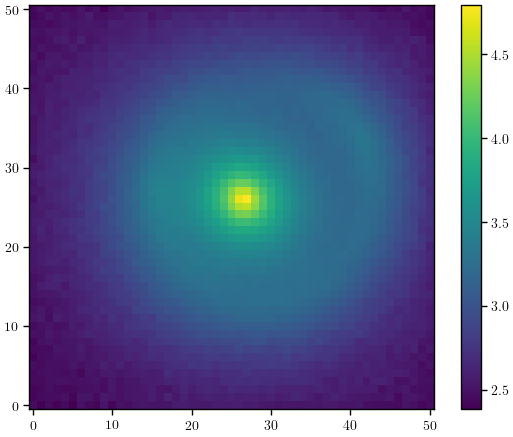

In [119]:
lens_without = deepcopy(lens)

synth_without = SyntheticImage(lens_without,
                                roman,
                                band=band,
                                arcsec=side,
                                oversample=grid_oversample,
                                instrument_params=instrument_params,
                                pieces=False,
                                verbose=True)

engine_params = {
    'rng': rng,
    'nonlinearity': False,
}
exposure_without = Exposure(synth_without,
                                exposure_time=exposure_time,
                                engine_params=engine_params,
                                psf=psf,
                                verbose=True)

poisson_noise = exposure_without.poisson_noise
reciprocity_failure = exposure_without.reciprocity_failure
dark_noise = exposure_without.dark_noise
# nonlinearity = exposure_without.nonlinearity
ipc = exposure_without.ipc
read_noise = exposure_without.read_noise

plt.imshow(np.log10(exposure_without.exposure))
plt.colorbar()
plt.show()

Computing on pixel grid of size 255x255 (5.61"x5.61") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Building adaptive grid
Computing with 'adaptive' mode and supersampling factor 3
Adaptive grid: (255, 255)
Initialized SyntheticImage for StrongLens 00011398 by Roman in F129 band
Exposure calculation time with galsim engine: 0:00:00


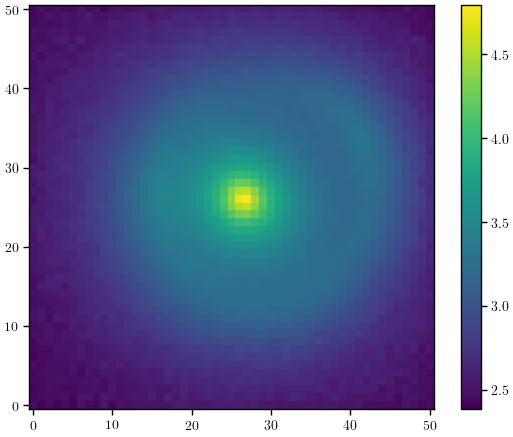

In [120]:
lens_with = deepcopy(lens)

realization = lens_with.generate_cdm_subhalos()
lens_with.add_subhalos(realization, mass_sheet_correction=False)

synth_with = SyntheticImage(lens_with,
                            roman,
                            band=band,
                            arcsec=side,
                            oversample=grid_oversample,
                            instrument_params=instrument_params,
                            verbose=True)

engine_params = {
    'rng': rng,
    'poisson_noise': poisson_noise,
    'dark_noise': dark_noise,
    'reciprocity_failure': reciprocity_failure,
    'nonlinearity': False,
    'ipc': ipc,
    'read_noise': read_noise
}
exposure_with = Exposure(synth_with,
                    exposure_time=exposure_time,
                    engine_params=engine_params,
                    psf=psf,
                    verbose=True)

plt.imshow(np.log10(exposure_with.exposure))
plt.colorbar()
plt.show()

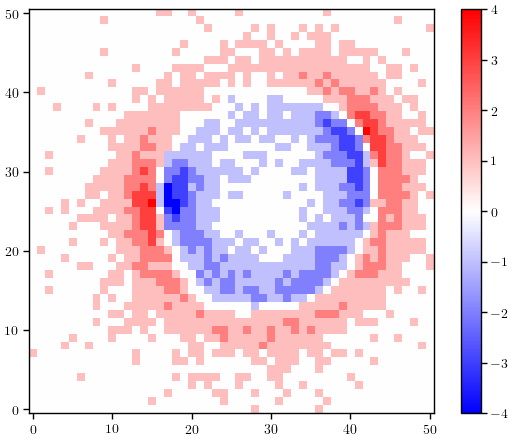

In [121]:
plt.imshow(exposure_with.exposure - exposure_without.exposure, norm=colors.CenteredNorm(), cmap='bwr')
plt.colorbar()
plt.show()

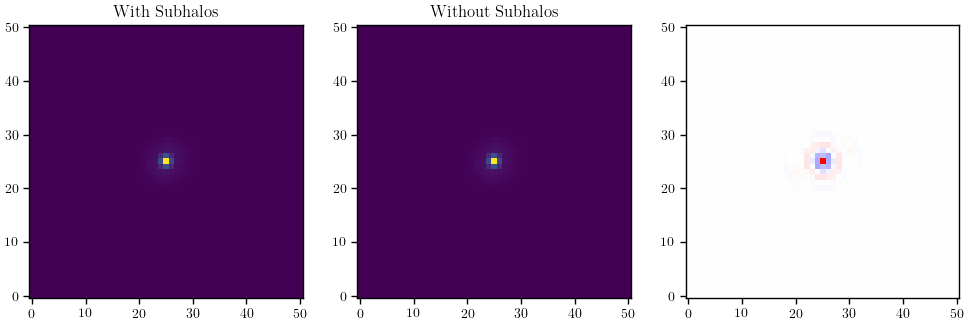

In [122]:
ps1d_with, r = correlation.power_spectrum_1d(exposure_with.exposure)
ps1d_without, _ = correlation.power_spectrum_1d(exposure_without.exposure)

ps2d_with = correlation.power_spectrum_2d(exposure_with.exposure)
ps2d_without = correlation.power_spectrum_2d(exposure_without.exposure)

f, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(ps2d_with)
ax[0].set_title('With Subhalos')

ax[1].imshow(ps2d_without)
ax[1].set_title('Without Subhalos')

ax[2].imshow(ps2d_with - ps2d_without, norm=colors.CenteredNorm(), cmap='bwr')

plt.show()

1. an image of a strong lens,
2. the image of the same strong lens with substructure,
3. residual of the two,
4. histogram of the pixel photon counts with and without subtructure,
5. 1D power spectrum with and without substructure overplotted,
6. Residual between the 2D power spectra (with and without substructure)?

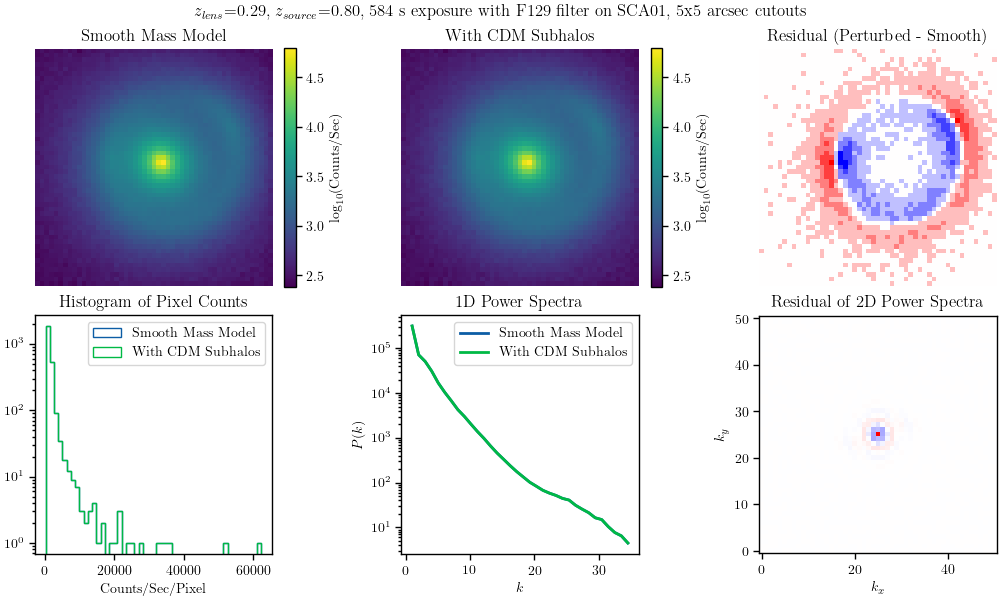

In [125]:
f, ax = plt.subplots(2, 3, figsize=(10, 6), constrained_layout=True)

im = ax[0, 0].imshow(np.log10(exposure_without.exposure))
ax[0, 0].set_title('Smooth Mass Model')
ax[0, 0].axis('off')
plt.colorbar(im, ax=ax[0, 0], label=r'$\log_{10}$(Counts/Sec)')

im = ax[0, 1].imshow(np.log10(exposure_with.exposure))
ax[0, 1].set_title('With CDM Subhalos')
ax[0, 1].axis('off')
plt.colorbar(im, ax=ax[0, 1], label=r'$\log_{10}$(Counts/Sec)')

ax[0, 2].imshow(exposure_with.exposure - exposure_without.exposure, norm=colors.CenteredNorm(), cmap='bwr')
ax[0, 2].set_title('Residual (Perturbed - Smooth)')
ax[0, 2].axis('off')

bins = int(np.sqrt(exposure_without.exposure.shape[0] * exposure_without.exposure.shape[1]))
ax[1, 0].hist(exposure_without.exposure.flatten(), bins=bins, histtype='step', label='Smooth Mass Model')
ax[1, 0].hist(exposure_with.exposure.flatten(), bins=bins, histtype='step', label='With CDM Subhalos')
ax[1, 0].set_title('Histogram of Pixel Counts')
ax[1, 0].set_xlabel('Counts/Sec/Pixel')
ax[1, 0].set_yscale('log')
ax[1, 0].legend()

ax[1, 1].plot(r, ps1d_without, label='Smooth Mass Model')
ax[1, 1].plot(r, ps1d_with, label='With CDM Subhalos')
ax[1, 1].set_title('1D Power Spectra')
ax[1, 1].set_xlabel(r'$k$')
ax[1, 1].set_ylabel(r'$P(k)$')
ax[1, 1].set_yscale('log')
ax[1, 1].legend()

ax[1, 2].imshow(ps2d_with - ps2d_without, cmap='bwr', norm=colors.CenteredNorm())
ax[1, 2].set_title('Residual of 2D Power Spectra')
ax[1, 2].set_xlabel(r'$k_x$')
ax[1, 2].set_ylabel(r'$k_y$')
ax[1, 2].set_aspect('equal')

plt.suptitle(r'$z_{lens}$=' + f'{lens.z_lens:.2f}, ' + r'$z_{source}$=' + f'{lens.z_source:.2f}, {exposure_time} s exposure with {band} filter on SCA{str(sca).zfill(2)}, 5x5 arcsec cutouts')
plt.savefig('example.png')
plt.show()

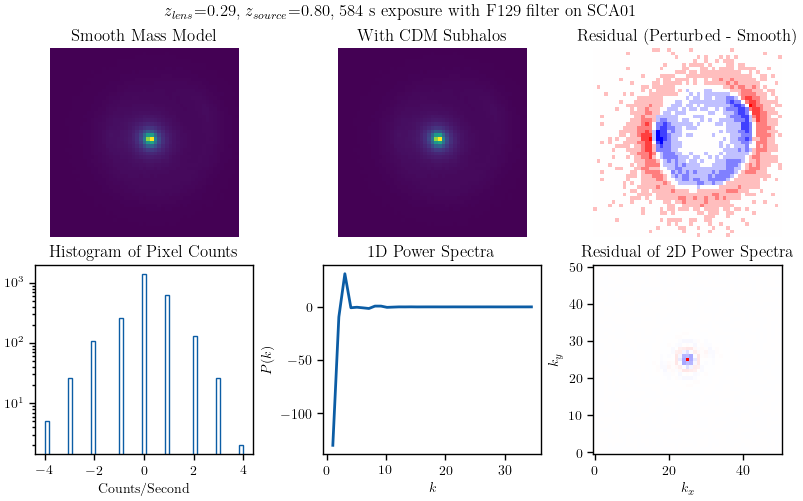

In [124]:
f, ax = plt.subplots(2, 3, figsize=(8, 5), constrained_layout=True)

ax[0, 0].imshow(exposure_without.exposure)
ax[0, 0].set_title('Smooth Mass Model')
ax[0, 0].axis('off')

ax[0, 1].imshow(exposure_with.exposure)
ax[0, 1].set_title('With CDM Subhalos')
ax[0, 1].axis('off')

ax[0, 2].imshow(exposure_with.exposure - exposure_without.exposure, norm=colors.CenteredNorm(), cmap='bwr')
ax[0, 2].set_title('Residual (Perturbed - Smooth)')
ax[0, 2].axis('off')

bins = int(np.sqrt(exposure_without.exposure.shape[0] * exposure_without.exposure.shape[1]))
ax[1, 0].hist((exposure_with.exposure - exposure_without.exposure).flatten(), bins=bins, histtype='step')
ax[1, 0].set_title('Histogram of Pixel Counts')
ax[1, 0].set_xlabel('Counts/Second')
ax[1, 0].set_yscale('log')

ax[1, 1].plot(r, ps1d_with - ps1d_without)
ax[1, 1].set_title('1D Power Spectra')
ax[1, 1].set_xlabel(r'$k$')
ax[1, 1].set_ylabel(r'$P(k)$')
# ax[1, 1].set_yscale('log')

ax[1, 2].imshow(ps2d_with - ps2d_without, norm=colors.CenteredNorm(), cmap='bwr')
ax[1, 2].set_title('Residual of 2D Power Spectra')
ax[1, 2].set_xlabel(r'$k_x$')
ax[1, 2].set_ylabel(r'$k_y$')
ax[1, 2].set_aspect('equal')

plt.suptitle(r'$z_{lens}$=' + f'{lens.z_lens:.2f}, ' + r'$z_{source}$=' + f'{lens.z_source:.2f}, {exposure_time} s exposure with {band} filter on SCA{str(sca).zfill(2)}')
plt.savefig('example.png')
plt.show()